In [1]:
from arm import Gaussian

from posterior import ImproperGaussian

from environment import MAB, HMAB, FlatHMAB

from policy import (UCB, TS, 
                   MSs, MS0, MS1,
                   CatSEs, CatSE0, CatSE1)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from joblib import Parallel, delayed
import time
import tempfile
import shutil
import os

In [3]:
# Seed
# seed(1234)
# np.random.seed(1234)

In [4]:
def one_iter_mab(k, env, policy, horizon, tsav, nb_rep, cum_reward):
    random.seed(k)
    random.setstate(random.getstate())
    if nb_rep < 10 or k % (nb_rep / 10) == 0:
        print(k)
    result = env.play(policy, horizon)

    temp = np.zeros(horizon)
    for t in range(horizon):
        temp[t] = env.arms[result.choices[t]].expectation
    cum_reward[k, :] = np.cumsum(temp)[tsav]


def one_iter(k, env, policy, horizon, tsav, nb_rep, cum_reward):
    random.seed(k)
    random.setstate(random.getstate())
    if nb_rep < 10 or k % (nb_rep / 10) == 0:
        print(k)
    result = env.play(policy, horizon)

    temp = np.zeros(horizon)
    for t in range(horizon):
        temp[t] = env.arms[result.choices[0, t]][result.choices[1, t]].expectation
    cum_reward[k, :] = np.cumsum(temp)[tsav]

In [5]:
# Parameters
n_jobs = 30
graphic = 'yes'
save = 'no'
horizon = 10000
nb_rep = 100
scenario = 2
tsav = np.arange(horizon)
tsav_log = np.arange(100, horizon)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
c = 0

In [6]:
# Create structure
if scenario == 1:
    # Group-sparse + strong dominance
    nb_categories = 5
    nb_arms = [5] * nb_categories
    expectations = [[1, 0.5, 0.5, 0.5, 0], 
                    [0, -0.5, -0.5, -0.5, -1], 
                    [0, -0.5, -0.5, -0.5, -1], 
                    [0, -0.5, -0.5, -0.5, -1],
                    [0, -0.5, -0.5, -0.5, -1]]
    flathmab_policies = [CatSEs(nb_categories, nb_arms, c=2), 
                         CatSE0(nb_categories, nb_arms, c=2),
                         MSs(nb_categories, nb_arms, ImproperGaussian),
                         MS0(nb_categories, nb_arms, ImproperGaussian)]
elif scenario == 2:
    # First-order dominance
    nb_categories = 5
    nb_arms = [10] * nb_categories
    expectations = [[5, 4, 4, 4, 4, 4, 3, 3, 3, 2], 
                    [4.5, 3, 3, 3, 3, 3, 3, 3, 3, 0], 
                    [4.5, 3, 3, 3, 3, 3, 3, 3, 3, 0], 
                    [4.5, 3, 3, 3, 3, 3, 3, 3, 3, 0], 
                    [4.5, 3, 3, 3, 3, 3, 3, 3, 3, 0]]
    flathmab_policies = [CatSE1(nb_categories, nb_arms), 
                         MS1(nb_categories, nb_arms, ImproperGaussian)]
else:
    raise ValueError('scenario unknown')

mab_policies = [UCB(nb_categories * nb_arms[0], c=2),
                TS(nb_categories * nb_arms[0], ImproperGaussian)]
hmab_policies = [[UCB(nb_categories, c=2), UCB(nb_arms[0], c=2)]]

arms = [[Gaussian(expectations[i][j], 1) for j in range(nb_arms[i])] for i in range(nb_categories)]

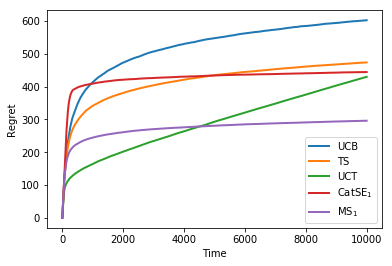

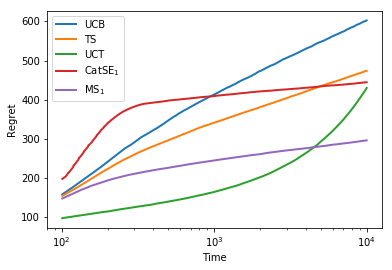

--- 366.21214389801025 seconds ---


In [7]:
start_time = time.time()

if graphic == 'yes':
    fig1 = plt.figure()
    fig1.clf()
    ax1 = plt.axes()
    fig2 = plt.figure()
    fig2.clf()
    ax2 = plt.axes()
    c = 0

with Parallel(n_jobs=n_jobs) as parallel:
    folder = tempfile.mkdtemp()
    rewards_name = os.path.join(folder, 'rewards')
    cum_reward = np.memmap(rewards_name, dtype='float64',
                            shape=(nb_rep, len(tsav)), mode='w+')

    try:
        # MAB
        env = MAB(np.ravel(arms))
        for policy in mab_policies:
            parallel(delayed(one_iter_mab)(k, env, policy, horizon, tsav, nb_rep, cum_reward) for k in range(nb_rep))

            mean_regret = (1 + tsav) * np.max([arm for category in expectations for arm in category]) - np.mean(cum_reward, 0)
            error = np.std(cum_reward, 0)
            if graphic == 'yes':
                ax1.plot(1 + tsav, mean_regret, linewidth=2, color=colors[c])
                ax2.semilogx(1 + tsav_log, mean_regret[tsav_log], linewidth=2, color=colors[c])
                c += 1
    
        # HMAB
        env = HMAB(arms)
        for policy in hmab_policies:
            parallel(delayed(one_iter)(k, env, policy, horizon, tsav, nb_rep, cum_reward) for k in range(nb_rep))

            mean_regret = (1 + tsav) * np.max([arm for category in expectations for arm in category]) - np.mean(cum_reward, 0)
            error = np.std(cum_reward, 0)
            if graphic == 'yes':
                ax1.plot(1 + tsav, mean_regret, linewidth=2, color=colors[c])
                ax2.semilogx(1 + tsav_log, mean_regret[tsav_log], linewidth=2, color=colors[c])
                c += 1

        # FlatHMAB
        env = FlatHMAB(arms)
        for policy in flathmab_policies:
            parallel(delayed(one_iter)(k, env, policy, horizon, tsav, nb_rep, cum_reward) for k in range(nb_rep))

            mean_regret = (1 + tsav) * np.max([arm for category in expectations for arm in category]) - np.mean(cum_reward, 0)
            error = np.std(cum_reward, 0)
            if graphic == 'yes':
                ax1.plot(1 + tsav, mean_regret, linewidth=2, color=colors[c])
                ax2.semilogx(1 + tsav_log, mean_regret[tsav_log], linewidth=2, color=colors[c])
                c += 1

        if graphic == 'yes':
            ax1.set_xlabel('Time')
            ax2.set_xlabel('Time')
            ax1.set_ylabel('Regret')
            ax2.set_ylabel('Regret')
            if scenario == 1:
                ax1.legend(['UCB', 'TS', 'UCT', 
                            '$\mathrm{CatSE}_s$', '$\mathrm{CatSE}_0$', 
                            '$\mathrm{MS}_s$', r'$\mathrm{MS}_0$'], loc='best')
                ax2.legend(['UCB', 'TS', 'UCT',
                            '$\mathrm{CatSE}_s$', '$\mathrm{CatSE}_0$',
                            '$\mathrm{MS}_s$', r'$\mathrm{MS}_0$'], loc='best')
            elif scenario == 2:
                ax1.legend(['UCB', 'TS', 'UCT', 
                            '$\mathrm{CatSE}_1$', '$\mathrm{MS}_1$'], loc='best')
                ax2.legend(['UCB', 'TS', 'UCT',
                            '$\mathrm{CatSE}_1$', '$\mathrm{MS}_1$'], loc='best')
        
        if save == 'yes':
            fig1.savefig('figures/exp_{}.eps'.format(str(scenario)), format='eps', bbox_inches='tight')
            fig2.savefig('figures/exp_log_{}.eps'.format(str(scenario)), format='eps', bbox_inches='tight')

    finally:
        shutil.rmtree(folder)


plt.show()

print("--- %s seconds ---" % (time.time() - start_time))